In [2]:
using Revise
using DrWatson

In [3]:
@quickactivate :ReactiveMPPaperExperiments

┌ Info: Precompiling ReactiveMPPaperExperiments [adcd1038-27e6-4580-819b-caa5dba07e45]
└ @ Base loading.jl:1342


In [4]:
using ForneyLab
using BenchmarkTools
using Random
using LinearAlgebra

In [5]:
import Distributions

In [220]:
params = let 
    seed = 42
    n    = 100
    d    = 4
    θ    = π / 20

    rng = MersenneTwister(seed)

    A = random_posdef_matrix(rng, d)
    B = random_posdef_matrix(rng, d)
    P = Matrix(Diagonal(ones(d)))
    Q = Matrix(Diagonal(ones(d)))

    @strdict seed n d θ A B P Q
end;

In [221]:
x_data, y_data = generate_data(LGSSMModel(), params);

In [222]:
g = FactorGraph()

model_d = params["d"]
model_n = params["n"]
model_A = params["A"]
model_B = params["B"]
model_P = params["P"]
model_Q = params["Q"]

@RV x0 ~ GaussianMeanVariance(zeros(model_d), Matrix(Diagonal(100.0 * ones(model_d)))) # Prior

x = Vector{Variable}(undef, model_n) # Pre-define vectors for storing latent and observed variables
y = Vector{Variable}(undef, model_n)

x_t_prev = x0

for t = 1:model_n
    @RV x[t] ~ GaussianMeanVariance(model_A*x_t_prev, model_P) # Process model
    @RV y[t] ~ GaussianMeanVariance(model_B*x[t], model_Q) # Observation model

    placeholder(y[t], :y, dims=(model_d,), index=t) # Indicate observed variable
    
    x_t_prev = x[t] # Prepare state for next section
end
;

In [223]:
@time begin
    algo = messagePassingAlgorithm(x) # Generate algorithm
    source_code = algorithmSourceCode(algo) # Generate source code for algorithm
    eval(Meta.parse(source_code)); # Load algorithm
end

 49.917084 seconds (5.96 M allocations: 3.365 GiB, 1.80% gc time)


step! (generic function with 3 methods)

In [224]:
@time begin
    algo = messagePassingAlgorithm(x) # Generate algorithm
    source_code = algorithmSourceCode(algo) # Generate source code for algorithm
    eval(Meta.parse(source_code)); # Load algorithm
end

 51.375236 seconds (5.79 M allocations: 3.356 GiB, 1.22% gc time)


step! (generic function with 3 methods)

In [225]:
@time begin
    algo = messagePassingAlgorithm(x) # Generate algorithm
    source_code = algorithmSourceCode(algo) # Generate source code for algorithm
    eval(Meta.parse(source_code)); # Load algorithm
end

 51.308101 seconds (5.79 M allocations: 3.356 GiB, 1.25% gc time)


step! (generic function with 3 methods)

In [226]:
# For DIMENSION = 2

# Because of the global evaluation we cannot robustly perform this benchmark in a loop like we did for Turing and ReactiveMP
# So we change number of observations by hand and perform benchmarks separately 
# ForneyLab model creation time times
# 50 - 25.843605 seconds (2.86 M allocations: 1.644 GiB, 1.32% gc time)
# 100 - 49.688046 seconds (5.76 M allocations: 3.313 GiB, 1.33% gc time)
# 250 - 127.433735 seconds (15.00 M allocations: 8.477 GiB, 1.32% gc time)

In [227]:
# For DIMENSION = 10

# Because of the global evaluation we cannot robustly perform this benchmark in a loop like we did for Turing and ReactiveMP
# So we change number of observations by hand and perform benchmarks separately 
# ForneyLab model creation time times
# 50 - 
# 100 - 
# 250 - 

In [228]:
data = Dict(:y => y_data) # Prepare data dictionary
;

In [229]:
@time step!(data);

 61.656482 seconds (3.34 M allocations: 147.673 MiB, 0.17% gc time, 99.99% compilation time)


In [230]:
# For DIMENSION = 2

# ForneyLab compilation time
# 50 - 13.489154 seconds (1.65 M allocations: 74.831 MiB, 0.23% gc time, 99.98% compilation time)
# 100 - 62.301726 seconds (3.17 M allocations: 139.764 MiB, 0.06% gc time, 99.99% compilation time)
# 250 - 537.946353 seconds (7.74 M allocations: 332.610 MiB, 0.02% gc time, 99.99% compilation time)

In [231]:
# For DIMENSION = 10

# ForneyLab compilation time
# 50 - 16.809911 seconds (2.05 M allocations: 90.020 MiB, 0.16% gc time, 99.97% compilation time)
# 100 - 
# 250 - 

In [232]:
@time step!(data);

  0.008794 seconds (39.64 k allocations: 4.605 MiB)


In [233]:
@time step!(data);

  0.008277 seconds (39.64 k allocations: 4.605 MiB)


In [234]:
@btime step!(data);

  3.763 ms (39642 allocations: 4.60 MiB)


In [235]:
inferred = step!(data) # Execute inference
marginals = map(i -> inferred[Symbol(:x_, i)], 1:model_n) 
;

In [236]:
average_mse(x_data, marginals)

6.525540105927179e58

In [164]:
# For DIMENSION = 2

# ForneyLab execution times and E[MSE]
# 50 - 1.482 ms (19742 allocations: 2.07 MiB) | E[MSE] = 15.275572234904864
# 100 - 3.329 ms (39642 allocations: 4.14 MiB) | E[MSE] = 21.969948269432027
# 250 - 8.189 ms (99600 allocations: 10.39 MiB) | E[MSE] = 33.6021951719447

In [28]:
# For DIMENSION = 10

# ForneyLab execution times
# 50 - 3.256 ms (19742 allocations: 3.83 MiB) | E[MSE] = 1.720501485263128e65
# 100 - 
# 250 - 

In [29]:
using CairoMakie

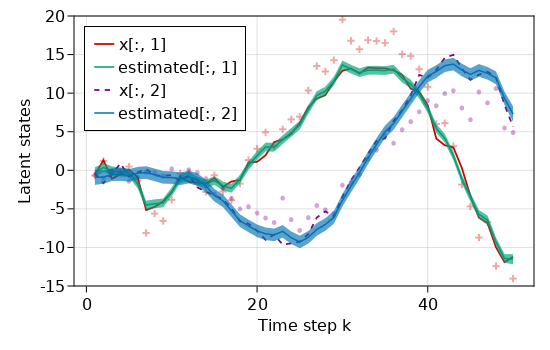

In [36]:
let
    ylimit = (-15, 20)
    c = Makie.wong_colors() 

    x_inferred_means = ForneyLab.unsafeMean.(marginals)
    x_inferred_stds  = map(e -> sqrt.(e), ForneyLab.unsafeVar.(marginals))
    
    range = 1:length(x_inferred_means)

    fig = Figure(resolution = (550, 350))
    ax  = Axis(fig[1, 1], xlabel = "Time step k", ylabel = "Latent states")

    ylims!(ax, ylimit)

    # Real dim1
    lines!(ax, range, x_data |> edim(1), color = :red3, linewidth = 1.75, label = "x[:, 1]",)
    scatter!(ax, range, y_data |> edim(1), color = (:red3, 0.35), markersize = 10, marker = :cross)

    # Estimated dim1

    lines!(ax, range, x_inferred_means |> edim(1), color = c[3], label = "estimated[:, 1]")
    band!(ax, range, (x_inferred_means |> edim(1)) .+ (x_inferred_stds |> edim(1)), (x_inferred_means |> edim(1)) .- (x_inferred_stds |> edim(1)), color = (c[3], 0.65))

    # Real dim2

    lines!(ax, range, x_data |> edim(2), color = :purple, linewidth = 1.75, linestyle = :dash, label = "x[:, 2]")
    scatter!(ax, range, y_data |> edim(2), color = (:purple, 0.35),markersize = 6, marker = :circle)

    # Estimated dim2

    lines!(ax, range, x_inferred_means |> edim(2), color = c[1], label = "estimated[:, 2]")
    band!(ax, range, (x_inferred_means |> edim(2)) .+ (x_inferred_stds |> edim(2)), (x_inferred_means |> edim(2)) .- (x_inferred_stds |> edim(2)), color = (c[1], 0.65))

    axislegend(ax, position = :lt)

    fig
end